In [1]:
from time import time
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import fetch_lfw_pairs

import xgboost as xgb
from sklearn.metrics import confusion_matrix, classification_report

In [84]:
lfw_dataset_train = fetch_lfw_pairs(subset='train', resize=0.4)
lfw_dataset_test = fetch_lfw_pairs(subset='test',resize=0.4)

In [85]:
X_train = lfw_dataset_train.data
y_train = lfw_dataset_train.target

X_test = lfw_dataset_test.data
y_test = lfw_dataset_test.target

In [86]:
def prepare_dataset(lfw_dataset):
    cnn_data_1 = []
    cnn_data_2 = []
    for images_paris in lfw_dataset['pairs']:
        image1 = images_paris[0]
        image2 = images_paris[1]
        image1 = image1.flatten()
        image2 = image2.flatten()
        cnn_data_1.append(image1)
        cnn_data_2.append(image2)
    cnn_data_1  = np.stack(cnn_data_1, axis=0)
    cnn_data_2  = np.stack(cnn_data_2, axis=0)
    
    return cnn_data_1, cnn_data_2


cnn_train_data_1, cnn_train_data_2 = prepare_dataset(lfw_dataset_train)
cnn_test_data_1, cnn_test_data_2 = prepare_dataset(lfw_dataset_test)

In [106]:
def pca_implementation(X_train, X_test):
    # Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
    # dataset): unsupervised feature extraction / dimensionality reduction
    n_components = 10

    print("Extracting the top %d eigenfaces from %d faces"
          % (n_components, X_train.shape[0]))
    t0 = time()
    pca = PCA(n_components=n_components, svd_solver='randomized',
              whiten=True).fit(X_train)
    print("done in %0.3fs" % (time() - t0))

    eigenfaces = pca.components_.reshape((n_components, 50, 37))

    print("Projecting the input data on the eigenfaces orthonormal basis")
    t0 = time()
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    print("done in %0.3fs" % (time() - t0))
    return X_train_pca, X_test_pca, eigenfaces

In [107]:
X_train_pca_1, X_test_pca_1, eigenfaces_1 = pca_implementation(cnn_train_data_1, cnn_test_data_1)
X_train_pca_2, X_test_pca_2, eigenfaces_2 = pca_implementation(cnn_train_data_2, cnn_test_data_2)

Extracting the top 10 eigenfaces from 2200 faces
done in 0.180s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.036s
Extracting the top 10 eigenfaces from 2200 faces
done in 0.193s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.036s


In [108]:
X_train_pca = np.hstack((X_train_pca_1,X_train_pca_2))
X_test_pca = np.hstack((X_test_pca_1,X_test_pca_2))

In [109]:
xgb_cl = xgb.XGBClassifier()

# Fit
xgb_cl.fit(X_train_pca, y_train)

# Predict
y_pred = xgb_cl.predict(X_test_pca)

# Score
accuracy_score(y_test, y_pred)

0.613

In [110]:
target = lfw_dataset_test.target
target_names = lfw_dataset_test.target_names


print(classification_report(y_pred, y_test, target_names=target_names))

                   precision    recall  f1-score   support

Different persons       0.58      0.62      0.60       465
      Same person       0.65      0.61      0.63       535

         accuracy                           0.61      1000
        macro avg       0.61      0.61      0.61      1000
     weighted avg       0.62      0.61      0.61      1000



#### Printing eigen face

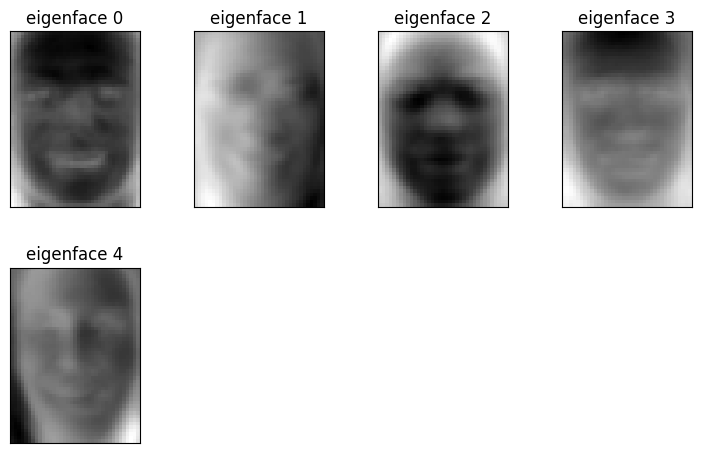

In [104]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(5):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces_1.shape[0])]
plot_gallery(eigenfaces_1, eigenface_titles, 50, 37)

plt.show()

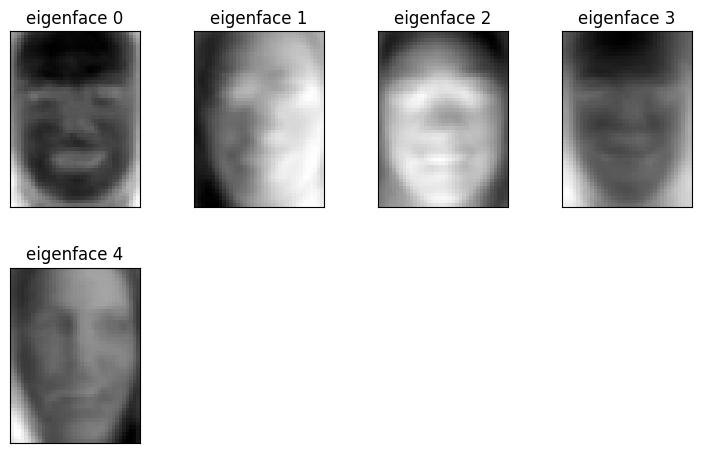

In [105]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces_2.shape[0])]
plot_gallery(eigenfaces_2, eigenface_titles, 50, 37)

plt.show()